In [ ]:
import requests
import datetime
import time
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import joblib
from google.colab import drive

In [ ]:
AGROMONITORING_API_KEY = "dfed845ac12c92a43c126aa42f94fb89"
OPENWEATHERMAP_API_KEY = "b98f28726ebfd5e4053e3939d22fe1af"

In [ ]:
url=f"https://rest.isric.org/soilgrids/v2.0/properties/query?lat={13.5372964}&lon={79.9934579}"
res=requests.get(url)
soil_data=json.dumps(res.json(),indent=5)
print(soil_data)

{
     "type": "Feature",
     "geometry": {
          "type": "Point",
          "coordinates": [
               79.9934579,
               13.5372964
          ]
     },
     "properties": {
          "layers": [
               {
                    "name": "bdod",
                    "unit_measure": {
                         "d_factor": 100,
                         "mapped_units": "cg/cm\u00b3",
                         "target_units": "kg/dm\u00b3",
                         "uncertainty_unit": ""
                    },
                    "depths": [
                         {
                              "range": {
                                   "top_depth": 0,
                                   "bottom_depth": 5,
                                   "unit_depth": "cm"
                              },
                              "label": "0-5cm",
                              "values": {
                                   "Q0.05": 74,
                                   "Q0.

In [ ]:
def get_soil_data_from_soil_grids(lat,long):
  url=f"https://rest.isric.org/soilgrids/v2.0/properties/query?lat={lat}&lon={long}"
  res=requests.get(url)
  soil_data=res.json()
  soil_features={}

  for layer in soil_data['properties']['layers']:
    layer_name=layer['name'].lower()
    if layer.get('depths'):
      top_depth=layer['depths'][0]['values']
      mean=top_depth.get('mean')
    else:
      mean=None
    if layer_name in ['phh2o','ph']:
      soil_features['ph']=mean/10 if mean is not None else None
    elif layer_name in ['phosphorous','p']:
      soil_features['P'] = mean
    elif layer_name in ['potassium', 'k']:
            soil_features['K'] = mean
    elif layer_name in ['nitrogen', 'n']:# in cg/kg
            soil_features['N'] = mean
    else:
      if 'soil_type' not in soil_features:
                soil_features['soil_type'] = layer['name']
  return soil_features

In [ ]:
def get_weather_data_from_agromonitoring(lat, long):

    url = f"http://api.agromonitoring.com/agro/1.0/weather?lat={lat}&lon={long}&appid={AGROMONITORING_API_KEY}"
    res = requests.get(url)
    weather_data = res.json()
    weather_features = {
        "temperature": weather_data.get("main", {}).get("temp"),  # in Kelvin
        "humidity": weather_data.get("main", {}).get("humidity"),  # in %
        "rainfall": weather_data.get("rain", {}).get("1h", 0),  # Last 1 hour rainfall (default 0)
    }

    # Convert temperature from K to °C
    if weather_features["temperature"] is not None:
        weather_features["temperature"] -= 273.15

    return weather_features

def get_combined_soil_weather_data(lat, long):
    soil_data = get_soil_data_from_soil_grids(lat, long)
    weather_data = get_weather_data_from_agromonitoring(lat, long)

    combined_data = {**soil_data, **weather_data}

    return combined_data


#Example Usage
latitude = 13.5372964
longitude =79.9934579
results= get_combined_soil_weather_data(latitude, longitude)
print(results)


{'soil_type': 'bdod', 'N': 224, 'ph': 7.0, 'temperature': 22.28000000000003, 'humidity': 86, 'rainfall': 0}


In [ ]:
Crop_recommendation_df=pd.read_csv("Crop_recommendation.csv")

In [ ]:
Crop_recommendation_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
Crop_recommendation_df.tail()

,N,P,K,temperature,humidity,ph,rainfall,label
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee


In [ ]:
Crop_recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
Crop_recommendation_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


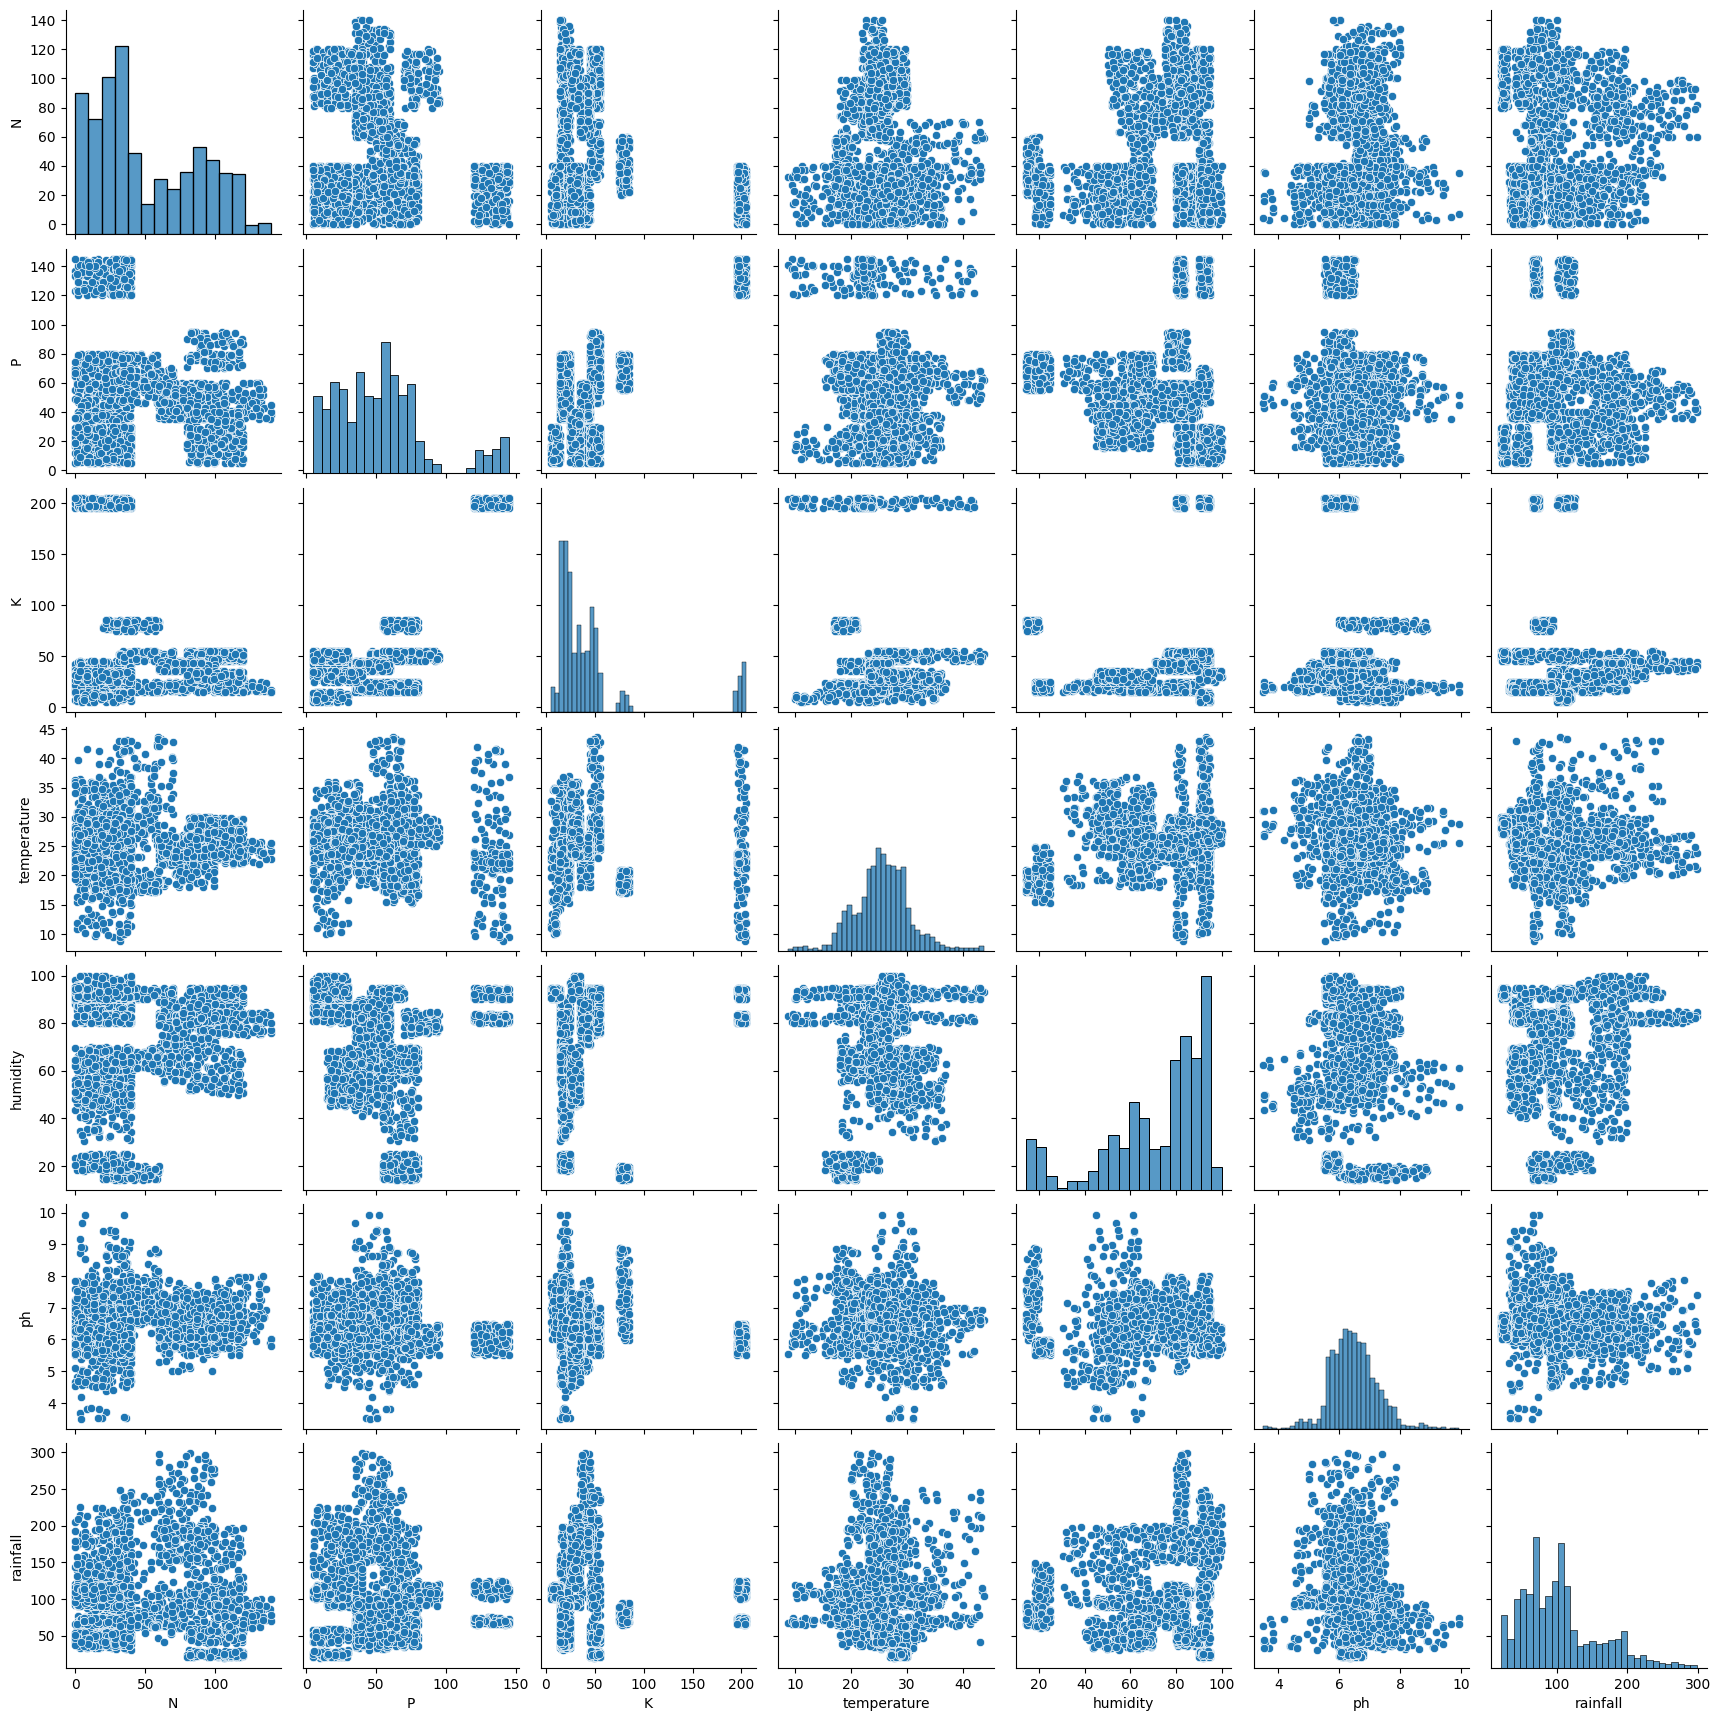

In [ ]:
sns.pairplot(Crop_recommendation_df) #None of the plots have shown the prefect correlation to eliminate some features

In [ ]:
Crop_recommendation_df['label'].value_counts() #Balanced data

,count
label,
rice,100
maize,100
jute,100
cotton,100
coconut,100
papaya,100
orange,100
apple,100
muskmelon,100


In [ ]:
X=Crop_recommendation_df.drop('label',axis=1)
y=Crop_recommendation_df['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
label_encoder=LabelEncoder()
scaler=StandardScaler()
#Encode the labels
y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.transform(y_test)
#Normalization
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
#model
model=RandomForestClassifier(n_estimators=30)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=30)

In [ ]:
joblib.dump(model,"crop_recommendation_model.pkl")

['crop_recommendation_model.pkl']

In [ ]:
model= joblib.load("crop_recommendation_model.pkl")

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
class_labels=Crop_recommendation_df['label'].unique()
class_mapping={i:label for i,label in enumerate(class_labels)}
y_test=[class_mapping[i] for i in y_test]
y_pred=[class_mapping[i] for i in y_pred]

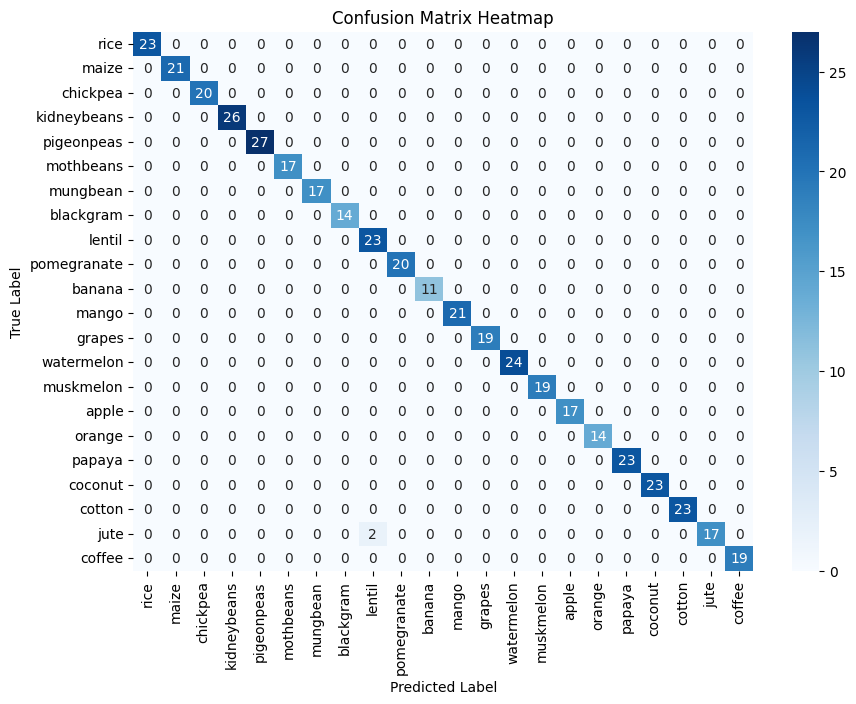

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=loaded_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_classes, yticklabels=loaded_classes)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        17
      banana       1.00      1.00      1.00        11
   blackgram       1.00      1.00      1.00        14
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        23
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        23
      grapes       1.00      1.00      1.00        19
        jute       1.00      0.89      0.94        19
 kidneybeans       1.00      1.00      1.00        26
      lentil       0.92      1.00      0.96        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        17
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        14
      papaya       1.00    

In [ ]:
def Crop_recommendation(latitude, longitude,manual_results=None,P=53.362727,K=48.149091): #manually input potassium and phosphorous values else used average from the collected data
  if manual_results:
    print("Using manually provided results...")
    results = manual_results
  else:
    results= get_combined_soil_weather_data(latitude, longitude)
    print(results)
  try:
      label=model.predict([[results['N']*1350*0.05*0.1, #to convert cg/kg to kg/ha
                      P,K,
                      results['temperature'],
                      results['humidity'],
                      results['ph'],
                      results['rainfall']]])
  except:
    return "Prediction failed."
  return class_mapping[label[0]]

In [ ]:
manual_data = {
    "N": 0.12,  # Example manually measured nitrogen (cg/kg)
    "temperature": 30.5,
    "humidity": 65,
    "ph": 6.5,
    "rainfall": 120
}

print(Crop_recommendation(13.5372964, 79.9934579, manual_results=manual_data))
print(Crop_recommendation(13.5372964, 79.9934579))


Using manually provided results...
rice
{'soil_type': 'bdod', 'N': 224, 'ph': 7.0, 'temperature': 22.28000000000003, 'humidity': 86, 'rainfall': 0}
rice


In [ ]:
def get_weather_forecast(lat, lon):
    url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={OPENWEATHERMAP_API_KEY}&units=metric"
    response = requests.get(url)
    data = response.json()

    forecast = {}
    for entry in data.get("list", []):
        date = entry["dt_txt"].split()[0]  # Extract date
        temp = entry["main"]["temp"]
        humidity = entry["main"]["humidity"]
        rainfall = entry.get("rain", {}).get("3h", 0)  # Rainfall in last 3 hours, default 0
        wind_speed = entry["wind"]["speed"]

        if date not in forecast:
            forecast[date] = {"Temperatures": [], "Humidity": [], "Rainfall": 0, "Wind Speeds": []}

        forecast[date]["Temperatures"].append(temp)
        forecast[date]["Humidity"].append(humidity)
        forecast[date]["Rainfall"] += rainfall
        forecast[date]["Wind Speeds"].append(wind_speed)
    daily_forecast = []
    for date, values in forecast.items():
        daily_forecast.append({
            "Date": date,
            "Avg Temperature (°C)": sum(values["Temperatures"]) / len(values["Temperatures"]),
            "Avg Humidity (%)": sum(values["Humidity"]) / len(values["Humidity"]),
            "Total Rainfall (mm)": values["Rainfall"],
            "Avg Wind Speed (m/s)": sum(values["Wind Speeds"]) / len(values["Wind Speeds"])
        })

    return daily_forecast[:5]

In [ ]:
get_weather_forecast(13.0827,80.2707)

[{'Date': '2025-02-20',
  'Avg Temperature (°C)': 25.705,
  'Avg Humidity (%)': 76.5,
  'Total Rainfall (mm)': 0,
  'Avg Wind Speed (m/s)': 2.805},
 {'Date': '2025-02-21',
  'Avg Temperature (°C)': 26.078750000000003,
  'Avg Humidity (%)': 70.0,
  'Total Rainfall (mm)': 0,
  'Avg Wind Speed (m/s)': 3.07375},
 {'Date': '2025-02-22',
  'Avg Temperature (°C)': 26.335000000000004,
  'Avg Humidity (%)': 68.75,
  'Total Rainfall (mm)': 0,
  'Avg Wind Speed (m/s)': 3.3575},
 {'Date': '2025-02-23',
  'Avg Temperature (°C)': 26.43,
  'Avg Humidity (%)': 69.0,
  'Total Rainfall (mm)': 0,
  'Avg Wind Speed (m/s)': 3.715},
 {'Date': '2025-02-24',
  'Avg Temperature (°C)': 26.73,
  'Avg Humidity (%)': 68.5,
  'Total Rainfall (mm)': 0,
  'Avg Wind Speed (m/s)': 3.4175000000000004}]